In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
import pandahouse
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
# Посмотрим сколько у нас пользователей в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
1,10079,10079,10079,10079
2,9952,9952,9952,9952
3,10049,10049,10049,10049
4,10070,10070,10070,10070


In [5]:
#считаем ctr контрольных групп
ctr_control_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
ctr_control_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

# Группы 0 и 3

In [16]:
#считаем linearized_likes
linearized_likes_0 = df[df.exp_group == 0].likes - ctr_control_0 * df[df.exp_group == 0].views
linearized_likes_0

7        -1.905973
11        5.878791
16       -0.707070
17       -3.080028
27        1.254083
           ...    
50124    -1.372959
50127    -2.196571
50130     0.459986
50143    10.844610
50144    -0.121209
Length: 9999, dtype: float64

In [17]:
#считаем linearized_likes
linearized_likes_3 = df[df.exp_group == 3].likes - ctr_control_0 * df[df.exp_group == 3].views
linearized_likes_3

0         2.752916
2         3.004666
9        -0.912973
13        2.668222
14       -3.537681
           ...    
50114    -1.874125
50118     7.757582
50122    12.089360
50145   -11.230752
50147     5.464652
Length: 10049, dtype: float64

In [10]:
#t-test on CTR

stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [11]:
#t-test on linearized_likes

stats.ttest_ind(linearized_likes_0,
                linearized_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

p-value стал чуть меньше, но особого отличия не видно, и так и так отклоняем гипотезу о равенстве средних в выборках

# Группы 1 и 2

In [18]:
#считаем linearized_likes
linearized_likes_1 = df[df.exp_group == 1].likes - ctr_control_1 * df[df.exp_group == 1].views
linearized_likes_1

1         0.343142
8        -4.032777
10       -6.514386
12      -10.058198
15       -1.945153
           ...    
50132     0.390633
50135    -5.357200
50138    -2.576590
50142    -0.393984
50146   -16.575934
Length: 10079, dtype: float64

In [19]:
#считаем linearized_likes
linearized_likes_2 = df[df.exp_group == 2].likes - ctr_control_1 * df[df.exp_group == 2].views
linearized_likes_2

3       -13.875592
5        -0.627431
6        21.277588
18       -5.521742
21        1.127759
           ...    
50131    -6.977930
50136    -0.248161
50137    -2.696992
50140   -14.970573
50148    -8.058198
Length: 9952, dtype: float64

In [20]:
#t-test on CTR

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [21]:
#t-test on linearized_likes

stats.ttest_ind(linearized_likes_1,
                linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

<AxesSubplot:ylabel='Count'>

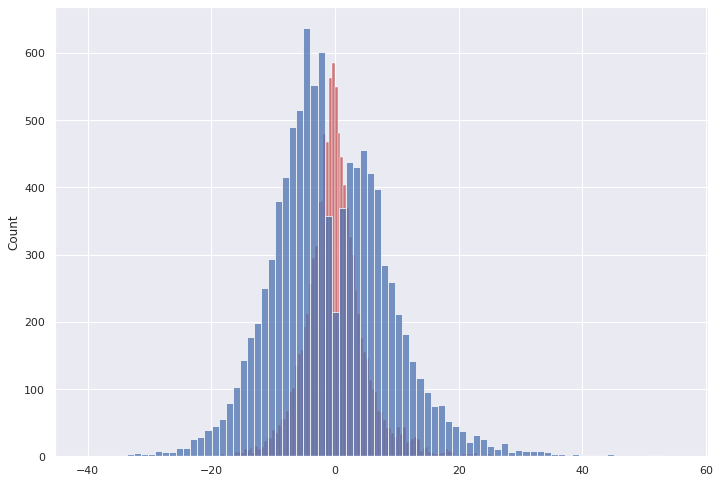

In [24]:
# Построим гистограммы распределения линеаризованных лайков по группам
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(linearized_likes_1, color='r')
sns.histplot(linearized_likes_2)

p-value в случае с линеаризованными лайками стал намного меньше и в отличие от случая с t-тестом по поюзерному CTR, по t-тесту на линеаризованных лайках отклоняем гипотезу о равенстве средних в выборках, что, как мы выяснили в прошлом задании, является более правдоподобным результатом.